In [12]:
# Import necessary packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime

In [13]:
# Matplotlib Style Settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.unicode_minus'] = False

In [14]:
df = pd.read_csv('./data/macro_processed.csv', index_col='Unnamed: 0')
df.index = pd.date_range('1970-01-01', '2024-05-01', freq='M')

In [15]:
# Split dataset into train data and test data.
# No randomness assumed since it is a time series data.

train_data = df.iloc[:624, :] # JAN1970 ~ DEC2021
test_data = df.iloc[624:, :]  # JAN2022 ~ APR2024

In [16]:
train_data.tail()

,ipi,uer,pce,ffr
2021-08-31,0.000024,-0.3,0.006917,-0.01
2021-09-30,-0.010685,-0.4,-0.003833,-0.01
2021-10-31,0.012471,-0.2,0.007314,0.00
2021-11-30,0.008860,-0.4,-0.005356,0.00
2021-12-31,-0.003079,-0.2,-0.004228,0.00


In [17]:
test_data.head()

,ipi,uer,pce,ffr
2022-01-31,0.001354,0.1,0.001873,0.00
2022-02-28,0.006452,-0.2,0.001249,0.00
2022-03-31,0.007851,-0.2,0.005366,0.12
2022-04-30,0.003091,0.1,-0.005728,0.13
2022-05-31,-0.000179,-0.1,-0.001912,0.44


In [18]:
# Model Selection
VARmodel = VAR(train_data)
lag_order = VARmodel.select_order(maxlags=12)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-21.55,-21.53,4.356e-10,-21.54
1,-22.82,-22.67,1.230e-10,-22.76
2,-23.14,-22.88,8.950e-11,-23.04
3,-23.29,-22.92*,7.641e-11,-23.15
4,-23.35,-22.86,7.235e-11,-23.16*
5,-23.38,-22.77,7.015e-11,-23.14
6,-23.40,-22.68,6.874e-11,-23.12
7,-23.42,-22.58,6.733e-11,-23.10
8,-23.48,-22.53,6.332e-11,-23.11
9,-23.55,-22.48,5.914e-11,-23.14


In [19]:
# Estimate the VAR model for the training set
results = VARmodel.fit(maxlags=12, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Jun, 2024
Time:                     00:29:25
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -22.2647
Nobs:                     613.000    HQIC:                  -23.0575
Log likelihood:           3922.54    FPE:                5.85579e-11
AIC:                     -23.5621    Det(Omega_mle):     4.41086e-11
--------------------------------------------------------------------
Results for equation ipi
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000089         0.000426            0.208           0.835
L1.ipi          0.178158         0.059957            2.971           0.003
L1.uer          0.008460         0.001297            6.521           0.000
L1.pce     

In [20]:
# Get the predicted values for the VAR model in the evaluation set
lag_order_aic = results.k_ar
lagged_values = train_data.values[-lag_order_aic:]

# Forecast for next 28 months
forecasted_values = results.forecast(y=lagged_values, steps=len(test_data))
forecast_cov = results.forecast_cov(steps=len(test_data))

# Combine the actual and forecasted values in a new dataframe for the evaluation set
eval_data_with_forecast = pd.DataFrame(index=test_data.index, columns=test_data.columns)
eval_data_with_forecast['ipi'] = forecasted_values[:, 0]
eval_data_with_forecast['ipi_actual'] = test_data['ipi']
eval_data_with_forecast['uer'] = forecasted_values[:, 1]
eval_data_with_forecast['uer_actual'] = test_data['uer']
eval_data_with_forecast['pce'] = forecasted_values[:, 2]
eval_data_with_forecast['pce_actual'] = test_data['pce']
eval_data_with_forecast['ffr'] = forecasted_values[:, 3]
eval_data_with_forecast['ffr_actual'] = test_data['ffr']

# Calculate the confidence interval for the forecasted value
for v in range(0, 4):
    v_label = train_data.columns[v]
    band_lower = np.zeros([len(test_data),1])
    band_upper = np.zeros([len(test_data),1])

    for h in range(0,len(test_data)):
        forecast_var = forecast_cov[h, v, v]
        forecast_sd = np.sqrt(forecast_var)

        band_upper[h,0] = forecasted_values[h,v] + 1.645 * forecast_sd
        band_lower[h,0] = forecasted_values[h,v] - 1.645 * forecast_sd
        
        eval_data_with_forecast[f'{v_label}_UPPER'] = band_upper
        eval_data_with_forecast[f'{v_label}_LOWER'] = band_lower

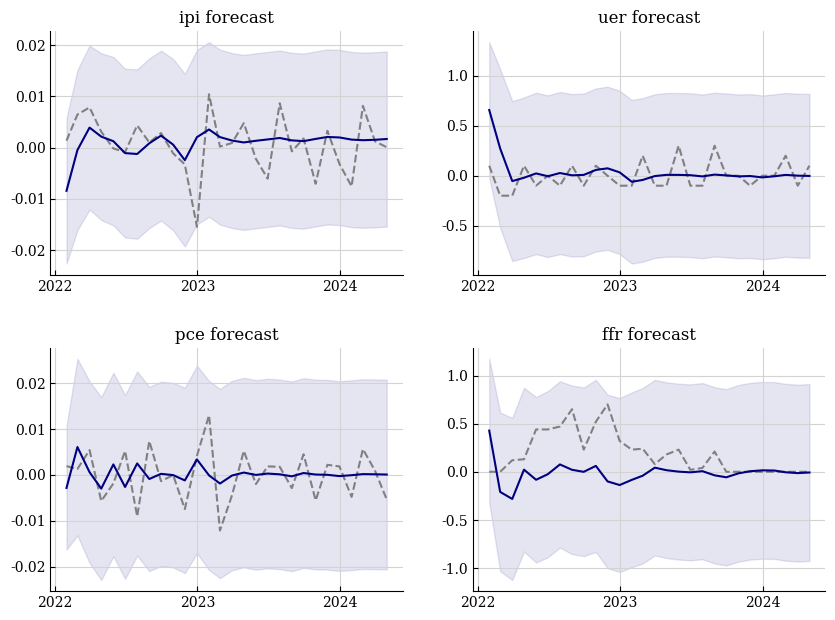

In [30]:
# Plot the predicted values and actual values for the prediction evaluation period
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
axs = axs.flatten()

for i, v in enumerate(train_data.columns):
    
    axs[i].plot(eval_data_with_forecast.index, eval_data_with_forecast[f'{v}_actual'], color='gray', ls='--', label=f'{v} actual')
    axs[i].plot(eval_data_with_forecast.index, eval_data_with_forecast[v], color='navy', label=f'{v} forecasted')
    
    axs[i].fill_between(eval_data_with_forecast.index, eval_data_with_forecast[f'{v}_LOWER'], eval_data_with_forecast[f'{v}_UPPER'], color='navy', alpha=0.1)
    axs[i].set_title(f'{v} forecast')
    axs[i].set_xticks(['2022', '2023', '2024'])
    axs[i].set_xticklabels(['2022', '2023', '2024'])
    #axs[i].legend()
    axs[i].grid(color='lightgray')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(direction='in')

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

In [32]:
# Save the figure.
fig.savefig('./figures/var_forecast.png')

In [52]:
# Save the forecasted data with confidence interval.
forecasts = eval_data_with_forecast.loc[:, ['ipi', 'uer', 'pce', 'ffr']]
CI = eval_data_with_forecast.loc[:, ['ipi_UPPER', 'ipi_LOWER', 'uer_UPPER', 'uer_LOWER', 'pce_UPPER', 'pce_LOWER', 'ffr_UPPER', 'ffr_LOWER']]

forecasts.to_csv('./data/var_forecasts.csv')
CI.to_csv('./data/var_forecasts_ci.csv')

In [42]:
results.fittedvalues.to_csv('./data/var_fittedvalues.csv')